In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from scipy.stats import shapiro, probplot
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

   subject#  age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0         1   72    0     5.6431       28.199       34.398    0.00662   
1         1   72    0    12.6660       28.447       34.894    0.00300   
2         1   72    0    19.6810       28.695       35.389    0.00481   
3         1   72    0    25.6470       28.905       35.810    0.00528   
4         1   72    0    33.6420       29.187       36.375    0.00335   

   Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  ...  Shimmer(dB)  Shimmer:APQ3  \
0     0.000034     0.00401      0.00317  ...        0.230       0.01438   
1     0.000017     0.00132      0.00150  ...        0.179       0.00994   
2     0.000025     0.00205      0.00208  ...        0.181       0.00734   
3     0.000027     0.00191      0.00264  ...        0.327       0.01106   
4     0.000020     0.00093      0.00130  ...        0.176       0.00679   

   Shimmer:APQ5  Shimmer:APQ11  Shimmer:DDA       NHR     HNR     RPDE  \
0       0.01309        0.01662      

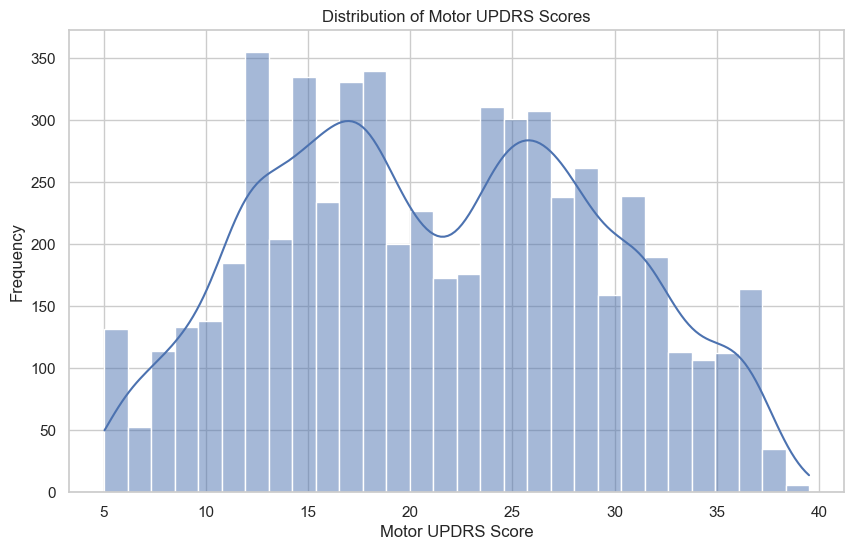

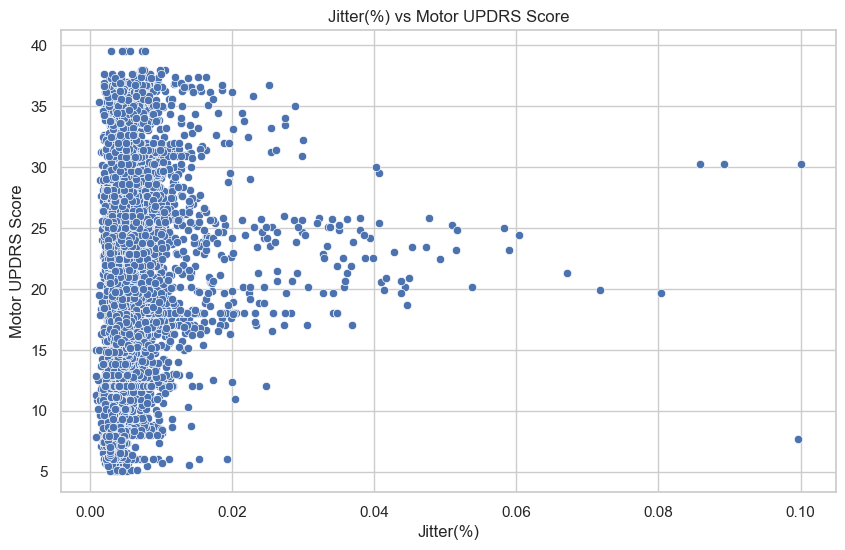

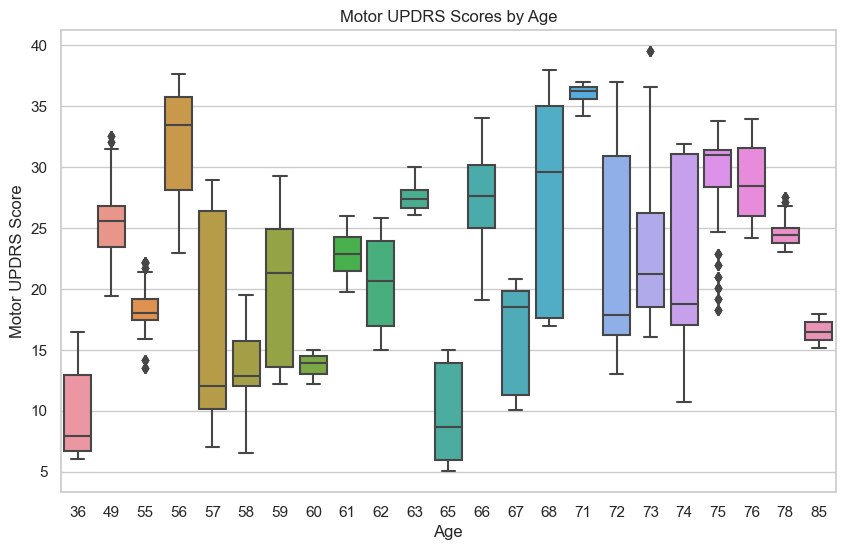

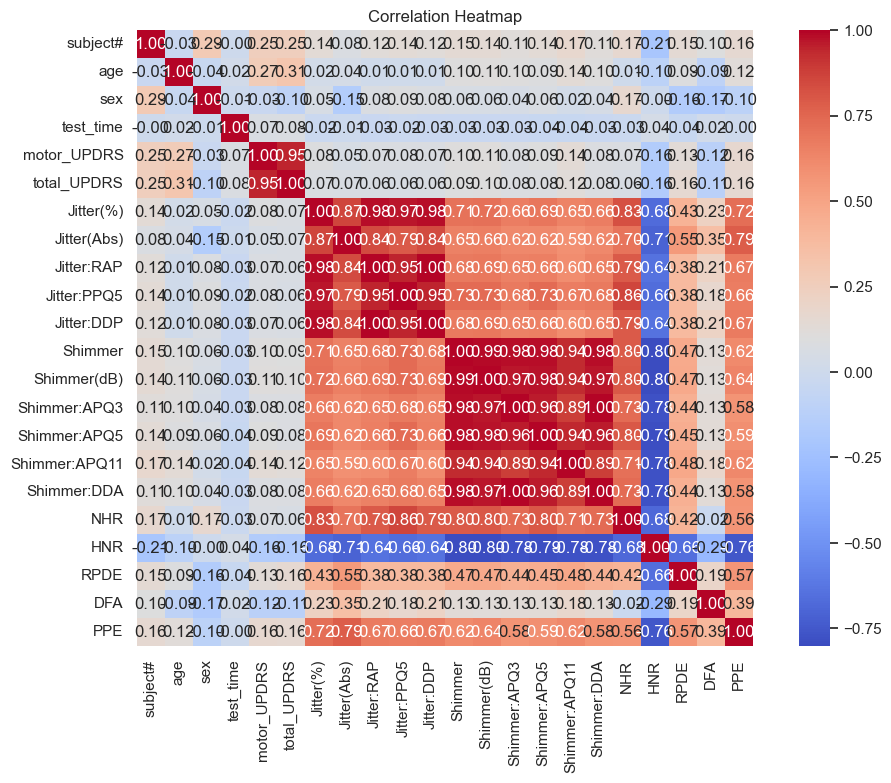

In [19]:
data = pd.read_csv('parkinsons+telemonitoring/parkinsons_updrs.data')  

# Preliminary look
print(data.head())
print(data.info())
print(data.describe())

sns.set(style='whitegrid')

# Distribution of motor UPDRS scores
plt.figure(figsize=(10, 6))
sns.histplot(data['motor_UPDRS'], bins=30, kde=True)
plt.title('Distribution of Motor UPDRS Scores')
plt.xlabel('Motor UPDRS Score')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of a voice feature vs motor UPDRS score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Jitter(%)', y='motor_UPDRS', data=data)
plt.title('Jitter(%) vs Motor UPDRS Score')
plt.xlabel('Jitter(%)')
plt.ylabel('Motor UPDRS Score')
plt.show()

# Boxplot of UPDRS scores by age
plt.figure(figsize=(10, 6))
sns.boxplot(x='age', y='motor_UPDRS', data=data)
plt.title('Motor UPDRS Scores by Age')
plt.xlabel('Age')
plt.ylabel('Motor UPDRS Score')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation = data.corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()


In [20]:

features = [
    'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 
    'Shimmer', 'Shimmer(dB)', 'NHR', 'HNR', 
    'RPDE', 'DFA', 'PPE', 'age', 'sex'
]
target = 'motor_UPDRS'  

# Prepare the feature matrix and target vector
X = data[features]
y = data[target]

# Add a constant to the model
X = sm.add_constant(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the OLS regression model
model = sm.OLS(y_train, X_train).fit()

print(model.summary())

# Predict on the test set and calculate R-squared
predictions = model.predict(X_test)
r_squared = model.rsquared
print(f'R-squared on the test set: {r_squared:.4f}')


                            OLS Regression Results                            
Dep. Variable:            motor_UPDRS   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     63.43
Date:                Tue, 17 Dec 2024   Prob (F-statistic):          4.12e-154
Time:                        19:11:50   Log-Likelihood:                -16156.
No. Observations:                4700   AIC:                         3.234e+04
Df Residuals:                    4686   BIC:                         3.243e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          29.5640      2.724     10.854      

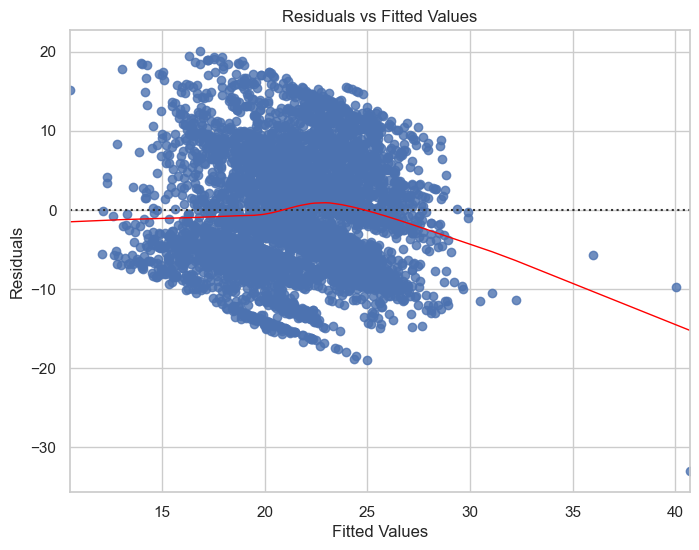

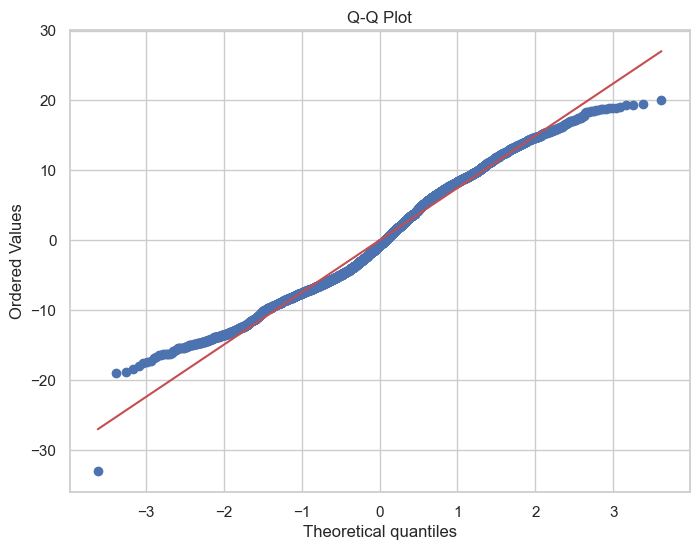

Shapiro-Wilk test p-value: 8.871765136209617e-23
Durbin-Watson statistic: 2.000185993372808
        feature         VIF
0         const  613.628550
1     Jitter(%)   82.797306
2   Jitter(Abs)    7.466526
3    Jitter:RAP   40.974946
4   Jitter:PPQ5   25.559272
5       Shimmer   70.469181
6   Shimmer(dB)   70.448700
7           NHR    7.392882
8           HNR    5.143281
9          RPDE    2.080735
10          DFA    1.641880
11          PPE    4.521869
12          age    1.089201
13          sex    1.352066


In [21]:
# Get residuals
residuals = model.resid
fitted_values = model.fittedvalues

# Residuals vs Fitted Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=fitted_values, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk test for normality
stat, p_value = shapiro(residuals)
print(f'Shapiro-Wilk test p-value: {p_value}')

# Durbin-Watson test statistic
dw_stat = sm.stats.durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data)


Explained variance ratio: [6.62478515e-01 9.84649639e-02 7.29986960e-02 5.89095748e-02
 4.48172941e-02 1.81600247e-02 1.31105917e-02 1.01624081e-02
 9.49553283e-03 6.05475281e-03 2.55944561e-03 1.19295931e-03
 8.23169571e-04 5.09570855e-04 2.62476961e-04 2.22224895e-08
 1.22605967e-09]


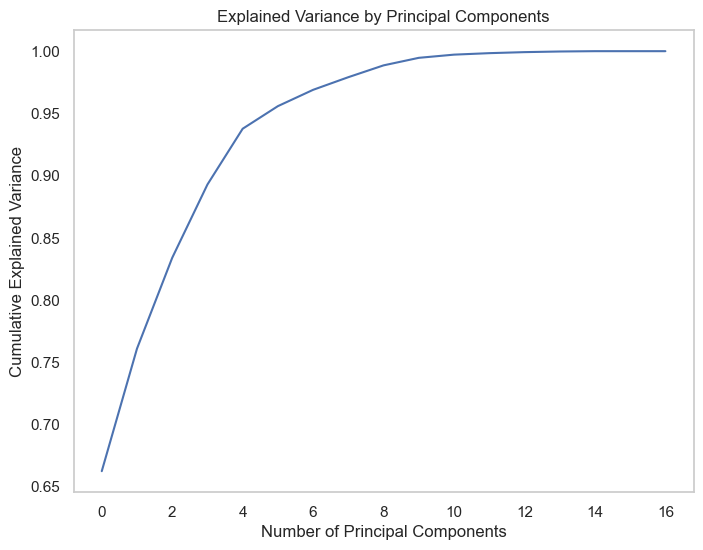

R^2 Score: 0.05054608006558625
Coefficients: [ 0.26588193  0.29411784 -0.03783835  0.46817953 -1.69057744]


In [22]:
# Select numerical features for PCA 
features = data.drop(columns=['subject#', 'motor_UPDRS', 'total_UPDRS', 'sex', 'age'])

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(features_scaled)

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Create a df for PCA results
pca_results = pd.DataFrame(
    data=principal_components, 
    columns=[f'PC{i+1}' for i in range(principal_components.shape[1])]
)

print("Explained variance ratio:", explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

# Use the first 5 principal components as predictors
X_pca = pca_results.iloc[:, :5]
y = data['motor_UPDRS']

model_pca = LinearRegression()
model_pca.fit(X_pca, y)

# Evaluate the model
print("R^2 Score:", model_pca.score(X_pca, y))
print("Coefficients:", model_pca.coef_)


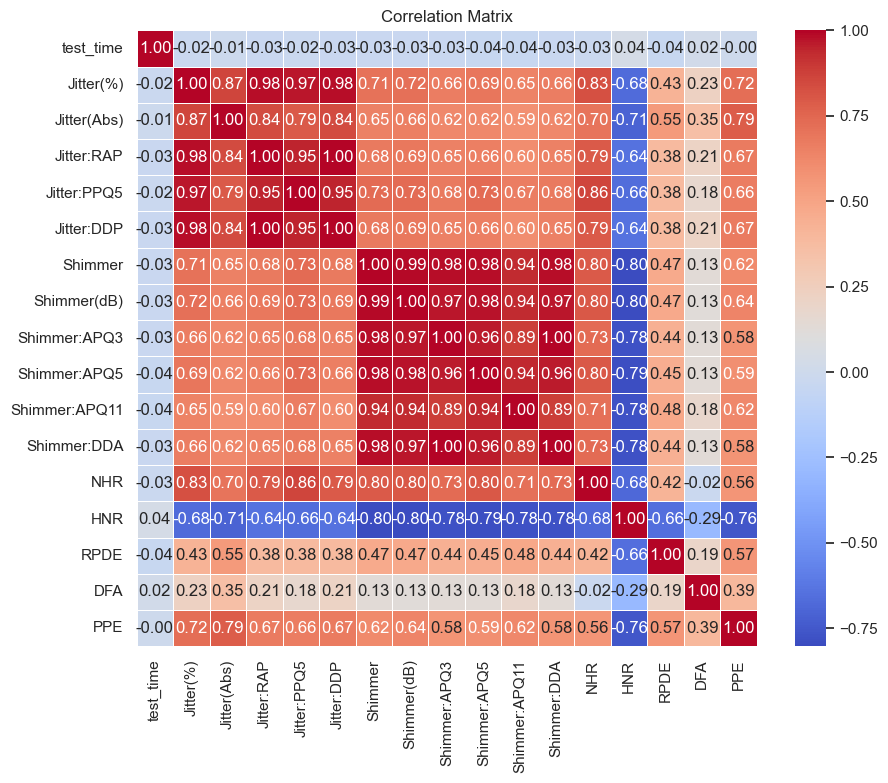

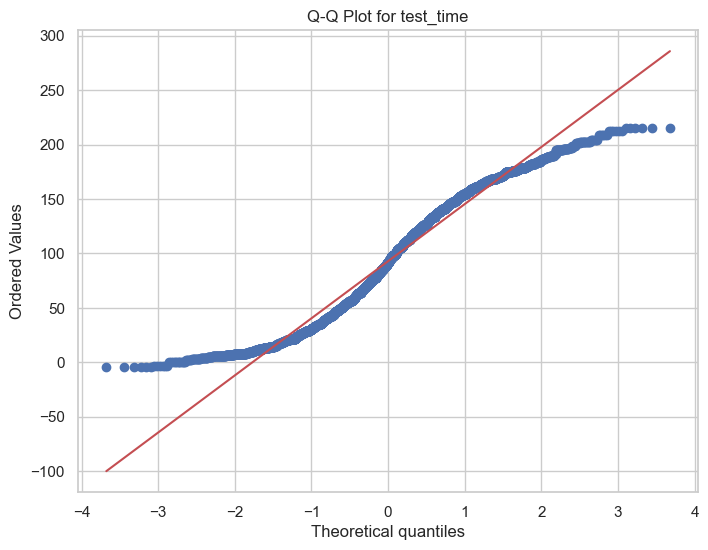

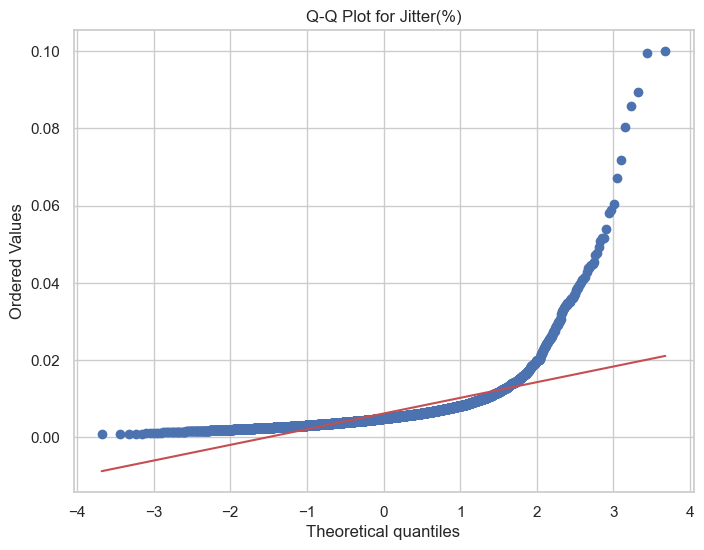

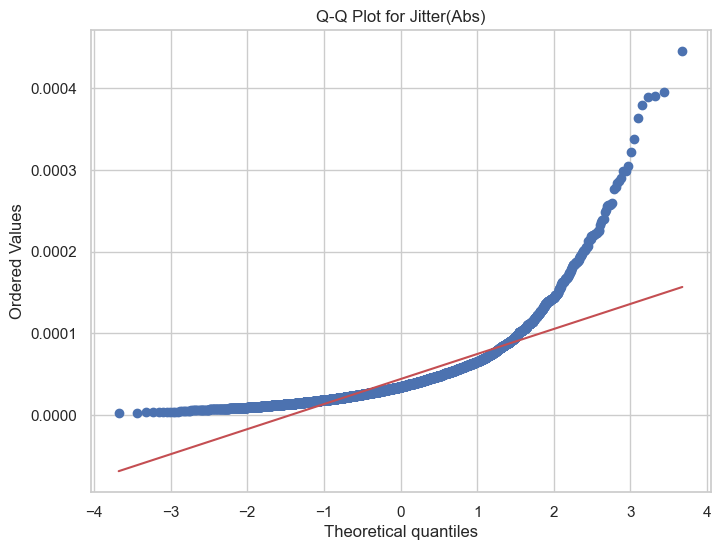

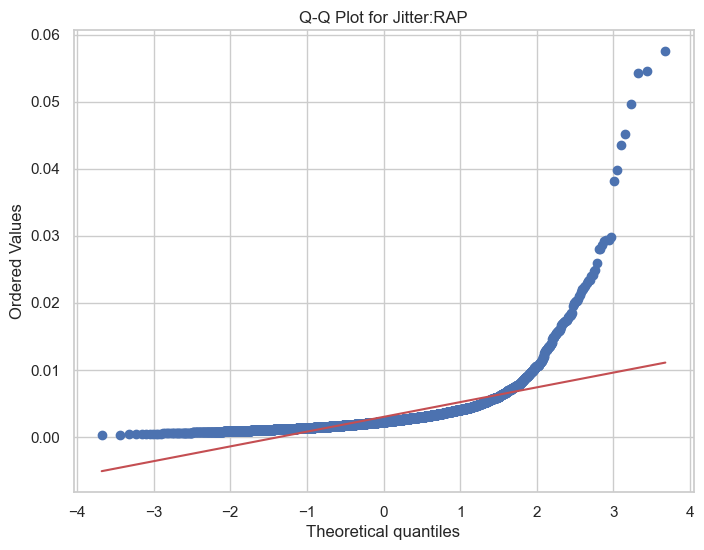

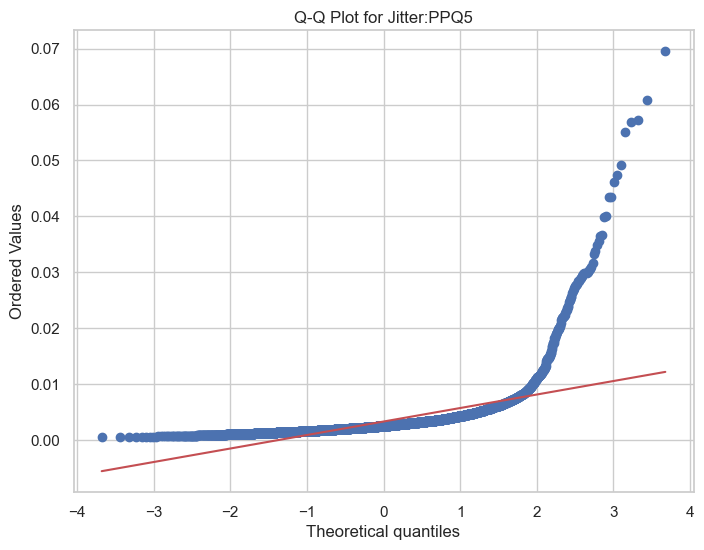

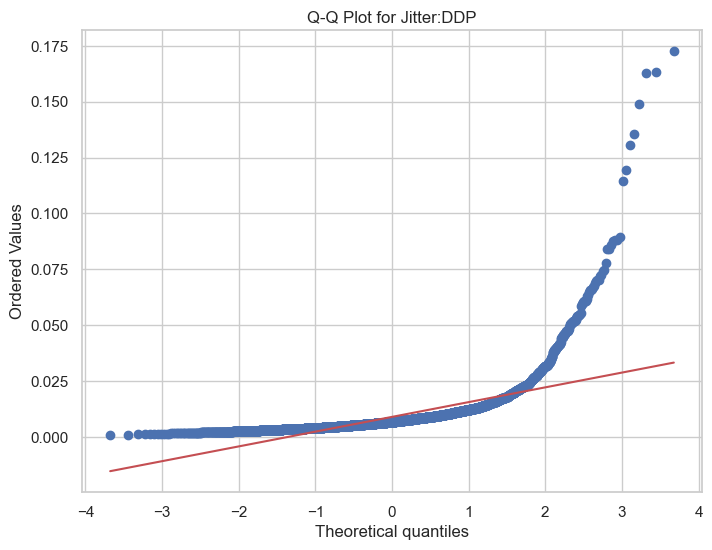

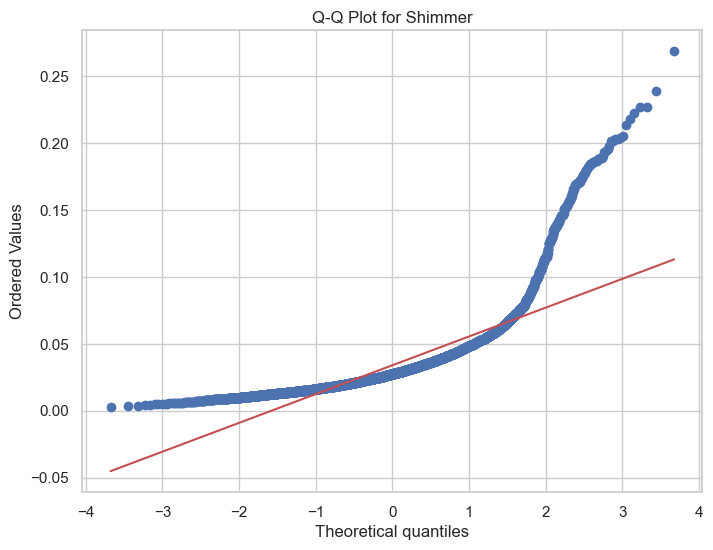

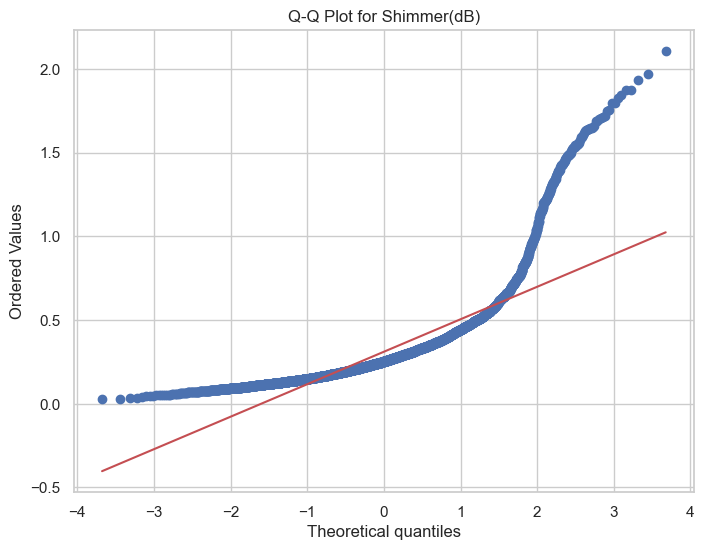

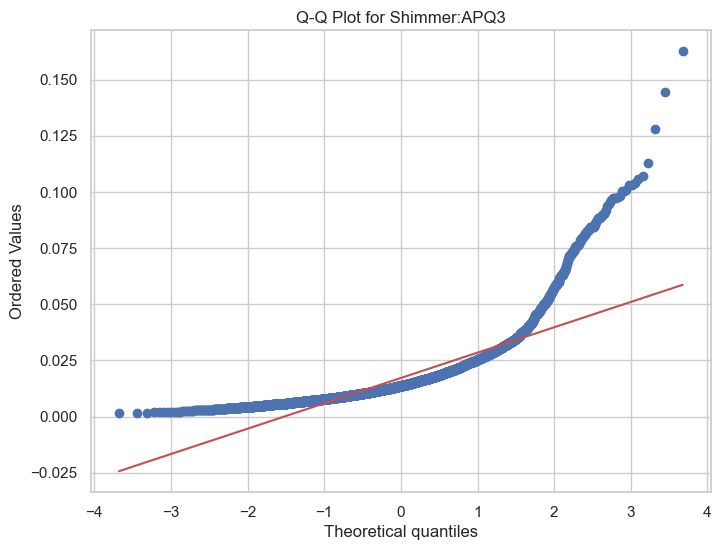

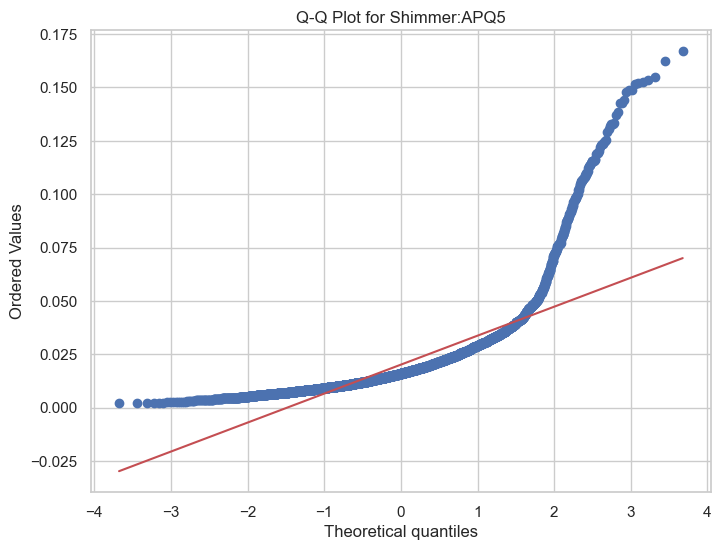

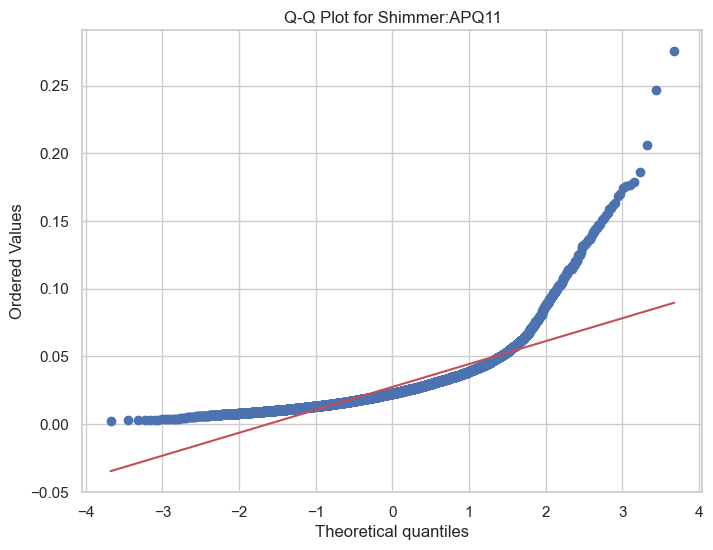

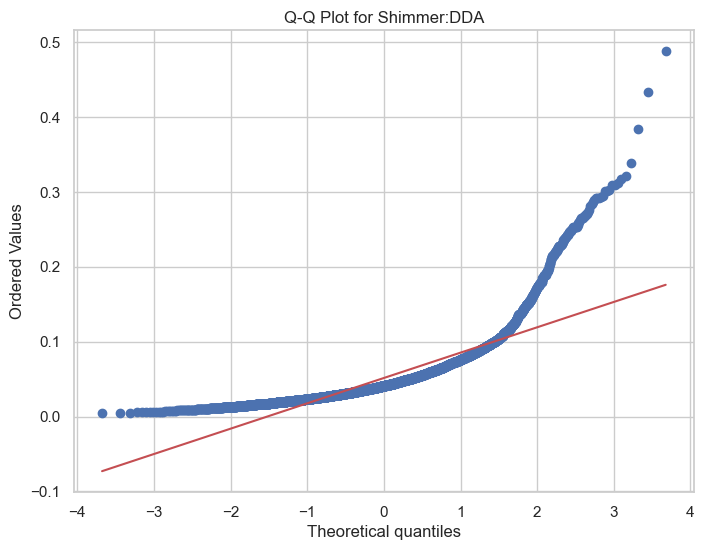

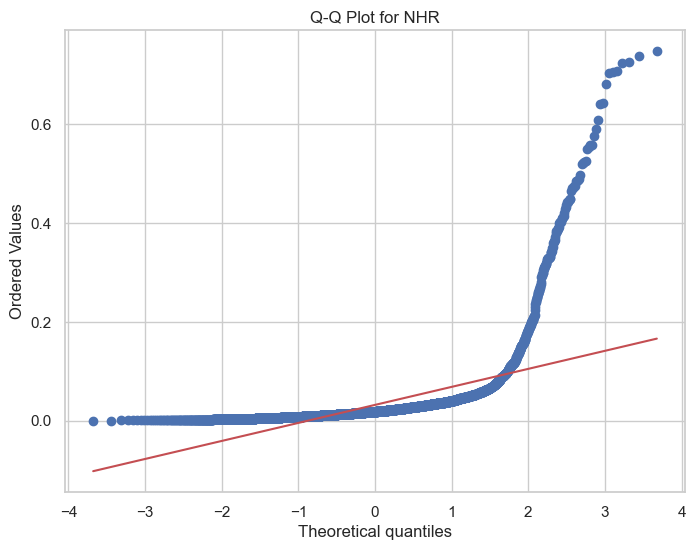

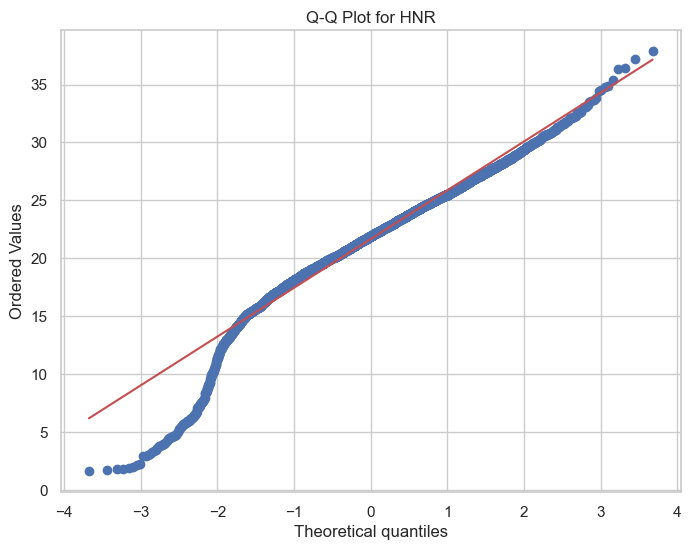

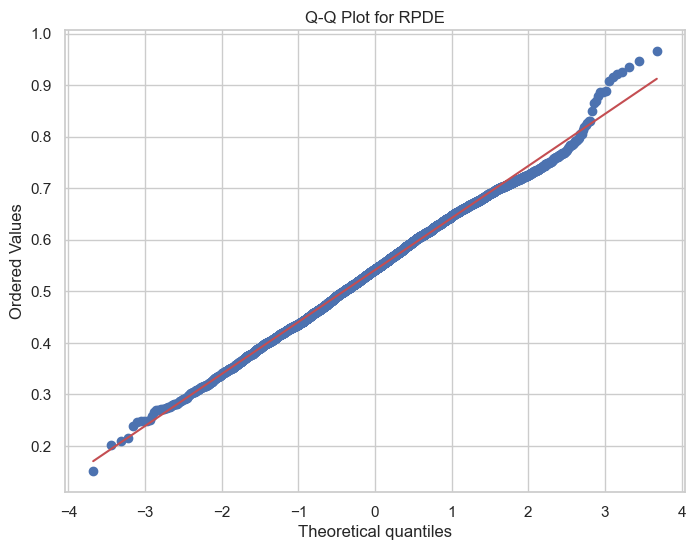

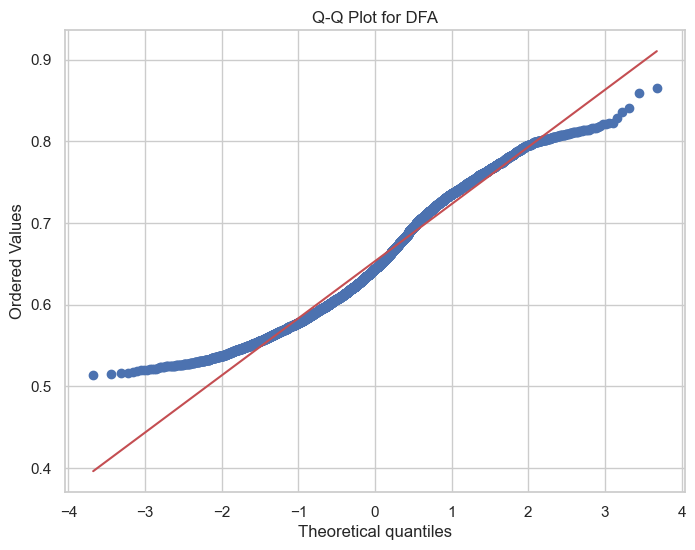

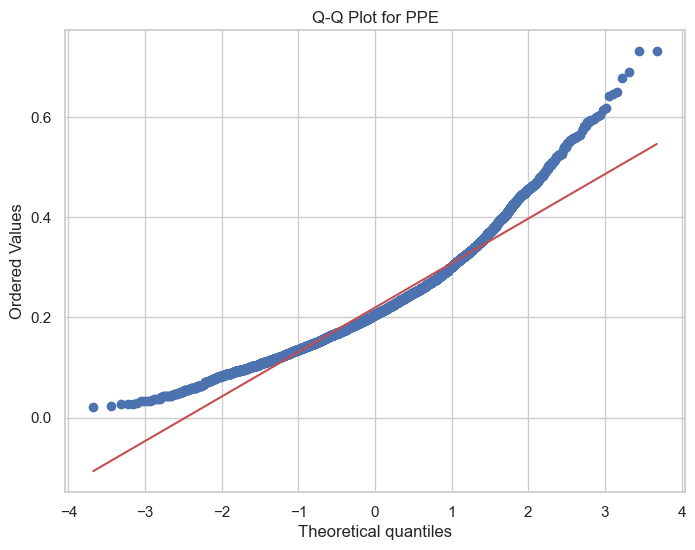

Shapiro-Wilk test p-value for test_time: 9.092157154163611e-37
Shapiro-Wilk test p-value for Jitter(%): 0.0
Shapiro-Wilk test p-value for Jitter(Abs): 0.0
Shapiro-Wilk test p-value for Jitter:RAP: 0.0
Shapiro-Wilk test p-value for Jitter:PPQ5: 0.0
Shapiro-Wilk test p-value for Jitter:DDP: 0.0
Shapiro-Wilk test p-value for Shimmer: 0.0
Shapiro-Wilk test p-value for Shimmer(dB): 0.0
Shapiro-Wilk test p-value for Shimmer:APQ3: 0.0
Shapiro-Wilk test p-value for Shimmer:APQ5: 0.0
Shapiro-Wilk test p-value for Shimmer:APQ11: 0.0
Shapiro-Wilk test p-value for Shimmer:DDA: 0.0
Shapiro-Wilk test p-value for NHR: 0.0
Shapiro-Wilk test p-value for HNR: 1.415408867237305e-37
Shapiro-Wilk test p-value for RPDE: 4.6342393034137785e-08
Shapiro-Wilk test p-value for DFA: 1.2533126645938984e-32
Shapiro-Wilk test p-value for PPE: 4.8765186558503634e-43
          feature           VIF
0       test_time  4.047901e+00
1       Jitter(%)  1.937309e+02
2     Jitter(Abs)  1.636148e+01
3      Jitter:RAP  2.5340

/Users/madelinedabney/miniconda3/envs/neu365p/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [23]:
# Correlation matrix 
corr_matrix = features.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Q-Q plots for the features 
for column in features.columns:
    plt.figure(figsize=(8, 6))
    stats.probplot(features[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {column}')
    plt.show()

# Shapiro-Wilk test for normality 
for column in features.columns:
    stat, p_value = shapiro(features[column])
    print(f'Shapiro-Wilk test p-value for {column}: {p_value}')

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif_data)

def bartlett_sphericity_test(X):
    # Calculate the correlation matrix
    corr_matrix = np.corrcoef(X.T)
    n, m = X.shape
    
    # Bartlett's test statistic
    k = m  # number of variables
    det_corr_matrix = np.linalg.det(corr_matrix)
    
    chi2_stat = -((n-1) - (2*k+5)/6) * np.log(det_corr_matrix)
    p_value = chi2.sf(chi2_stat, k*(k-1)//2)
    
    return chi2_stat, p_value

# Perform Bartlett's test
chi2_stat, p_value = bartlett_sphericity_test(features_scaled)
print(f'Bartlett\'s test statistic: {chi2_stat}')
print(f'Bartlett\'s test p-value: {p_value}')

# PCA loadings
loadings = pca.components_

# Create a df for loadings
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=features.columns)

print(loadings_df)


In [24]:
# Define Ridge model with hyperparameter tuning
ridge = Ridge()
param_grid = {'alpha': [0.1, 1, 10, 100, 1000]}
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')

# Fit the model to the training data
ridge_cv.fit(X_train, y_train)

# Best alpha
best_alpha_ridge = ridge_cv.best_params_['alpha']
print(f"Best alpha (Ridge): {best_alpha_ridge}")

# Evaluate Ridge model on test data
ridge_best = Ridge(alpha=best_alpha_ridge)
ridge_best.fit(X_train, y_train)
y_pred_ridge = ridge_best.predict(X_test)

# Metrics
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"Ridge Regression R^2: {r2_ridge}")
print(f"Ridge Regression MSE: {mse_ridge}")
print("Ridge Coefficients:", ridge_best.coef_)

# Repeat for Lasso
lasso = Lasso()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')

lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.best_params_['alpha']
print(f"Best alpha (Lasso): {best_alpha_lasso}")

lasso_best = Lasso(alpha=best_alpha_lasso)
lasso_best.fit(X_train, y_train)
y_pred_lasso = lasso_best.predict(X_test)

r2_lasso = r2_score(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print(f"Lasso Regression R^2: {r2_lasso}")
print(f"Lasso Regression MSE: {mse_lasso}")
print("Lasso Coefficients:", lasso_best.coef_)


Best alpha (Ridge): 0.1
Ridge Regression R^2: 0.09751018960378344
Ridge Regression MSE: 57.605225959468555
Ridge Coefficients: [  0.           8.12519477  -0.55883694   2.10083743   6.11518494
 -11.40233299  -2.32806421 -13.31785456  -0.4006903   -0.12538425
 -26.01042961  15.59407719   0.20976642  -0.20429168]
Best alpha (Lasso): 0.001
Lasso Regression R^2: 0.09727037287082319
Lasso Regression MSE: 57.62053327588575
Lasso Coefficients: [  0.           0.          -0.           0.           0.
  -0.          -3.58827927 -11.90124295  -0.39287199  -0.
 -25.63463354  15.66943803   0.21059632  -0.20522036]


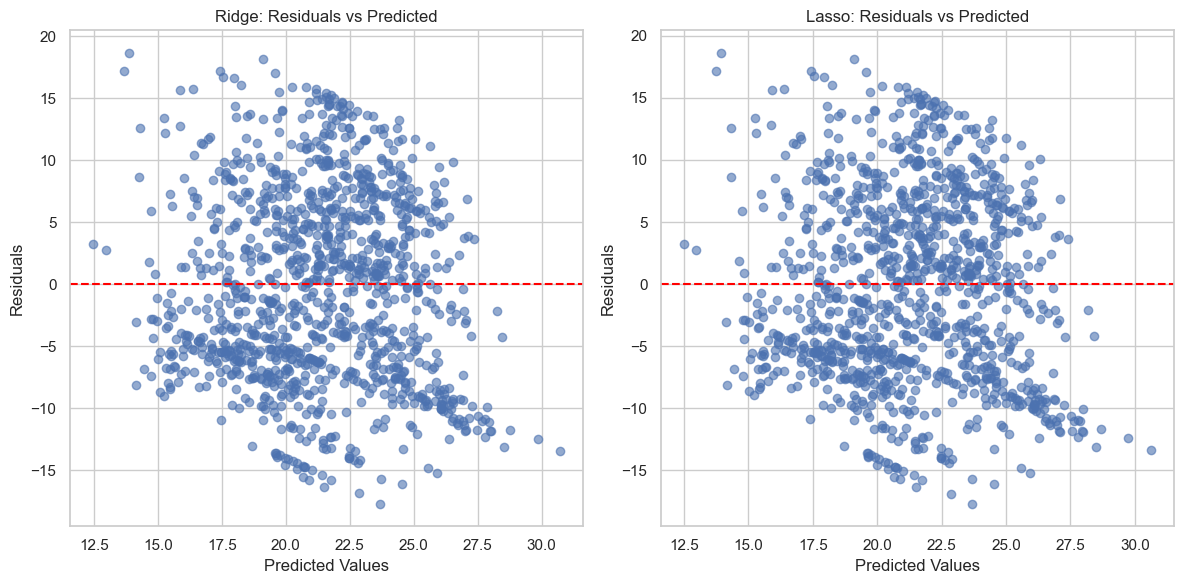

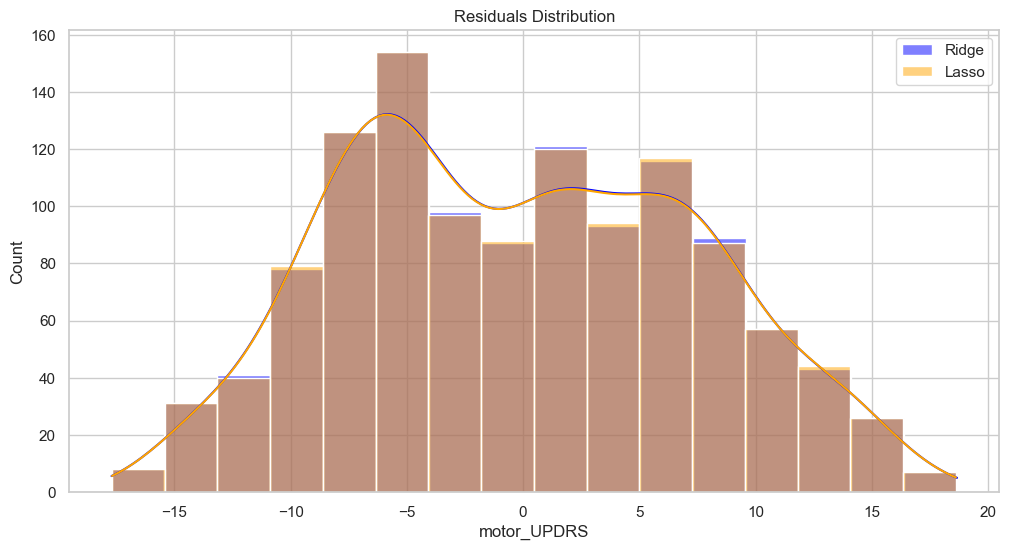

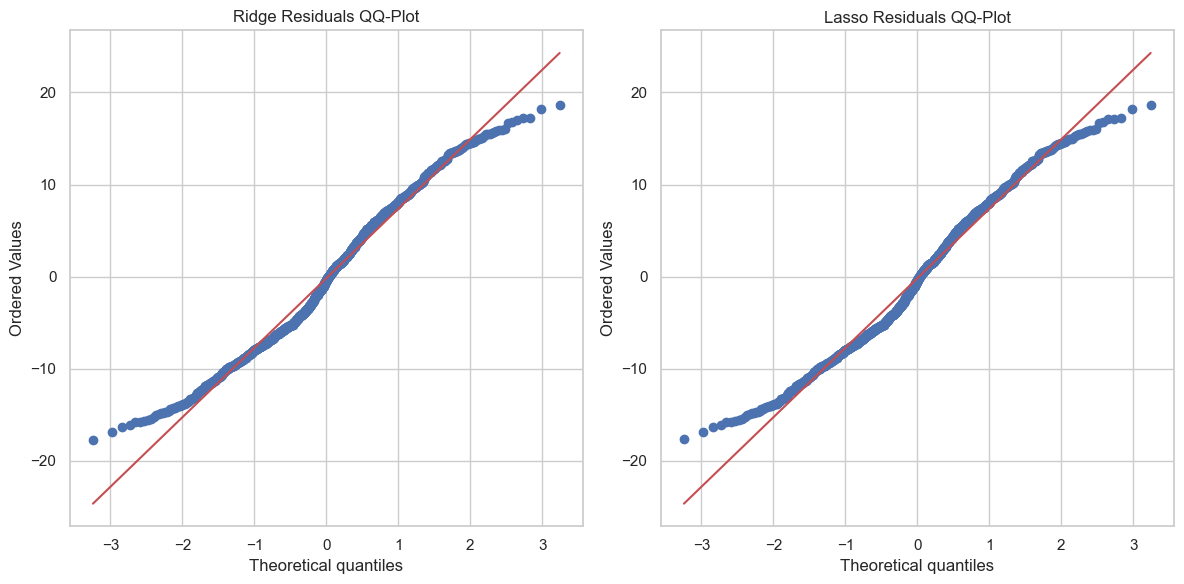

Ridge Shapiro-Wilk p-value: 7.469901780465804e-11
Lasso Shapiro-Wilk p-value: 6.817962167060543e-11
Ridge MSE: 57.605225959468555
Lasso MSE: 57.62053327588575


In [25]:
# Residuals
ridge_residuals = y_test - ridge_best.predict(X_test)
lasso_residuals = y_test - lasso_best.predict(X_test)

# Residual vs Predicted
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(ridge_best.predict(X_test), ridge_residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Ridge: Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

plt.subplot(1, 2, 2)
plt.scatter(lasso_best.predict(X_test), lasso_residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Lasso: Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(12, 6))
sns.histplot(ridge_residuals, kde=True, color='blue', label='Ridge', alpha=0.5)
sns.histplot(lasso_residuals, kde=True, color='orange', label='Lasso', alpha=0.5)
plt.title("Residuals Distribution")
plt.legend()
plt.show()

# QQ-Plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
probplot(ridge_residuals, dist="norm", plot=plt)
plt.title("Ridge Residuals QQ-Plot")

plt.subplot(1, 2, 2)
probplot(lasso_residuals, dist="norm", plot=plt)
plt.title("Lasso Residuals QQ-Plot")
plt.tight_layout()
plt.show()

# Shapiro-Wilk Test for Normality
ridge_shapiro = shapiro(ridge_residuals)
lasso_shapiro = shapiro(lasso_residuals)
print(f"Ridge Shapiro-Wilk p-value: {ridge_shapiro.pvalue}")
print(f"Lasso Shapiro-Wilk p-value: {lasso_shapiro.pvalue}")

# Mean Squared Error for Confirmation
ridge_mse = mean_squared_error(y_test, ridge_best.predict(X_test))
lasso_mse = mean_squared_error(y_test, lasso_best.predict(X_test))
print(f"Ridge MSE: {ridge_mse}")
print(f"Lasso MSE: {lasso_mse}")

